In [1]:
import pandas as pd
import numpy as np
from plotnine import *
pd.set_option('display.max_columns', None)

### Notes:

1. Some counties are having a mismatch in names. Need to manually resolve the name mismatch. Only with Opioid Shipment dataset. 

##### Final Report Structure

1. Intro - High Level <br>
2. Background - High Level <br>
3. EDA - Below<br>
4. Model ?? <br>
5. Results Findings on the diff-diff and pre-post plots. <br>
6. Conclusion Policy implementation effects summary <br>

For EDA, we can plot mortality rate and analyze trends across counties in target states. <br>
For EDA, we can also plot opioid shipment and analyze trends across counties in target states.

##### Open Questions
1. Do we need to create 2 drafts?
2. Do we need to merge opioid shipment data with drug mortality data.

### Import Mortality Dataset

In [2]:
mortality = pd.read_csv('../20_intermediate_files/mortality_non_aggregated.csv')
mortality = mortality.drop('Unnamed: 0', axis =1)

In [3]:
mortality.loc[mortality['State'] == 'AL', 'STATE'] = 'Alabama'
mortality.loc[mortality['State'] == 'FL', 'STATE'] = 'Florida'
mortality.loc[mortality['State'] == 'SC', 'STATE'] = 'South Carolina'
mortality.loc[mortality['State'] == 'GA', 'STATE'] = 'Georgia'
mortality.loc[mortality['State'] == 'TX', 'STATE'] = 'Texas'
mortality.loc[mortality['State'] == 'OK', 'STATE'] = 'Oklahoma'
mortality.loc[mortality['State'] == 'WA', 'STATE'] = 'Washington'
mortality.loc[mortality['State'] == 'NC', 'STATE'] = 'North Carolina'
mortality.loc[mortality['State'] == 'CO', 'STATE'] = 'Colorado'
mortality.loc[mortality['State'] == 'AZ', 'STATE'] = 'Arizona'
mortality.loc[mortality['State'] == 'CA', 'STATE'] = 'California'
mortality.loc[mortality['State'] == 'UT', 'STATE'] = 'Utah'

StateL = ['Florida', 'Alabama', 'South Carolina', 'Georgia', 'Texas', 'Arizona', 
          'California', 'Oklahoma','Washington','North Carolina','Utah','Colorado']



In [4]:
mortality = mortality[mortality['STATE'].isin(StateL)]
mortality.columns = ['YEAR', 'State_Abrv', 'COUNTY', 'DEATHS', 'STATE']
mortality['YEAR'] = mortality['YEAR'].astype(int)

### Import Population Dataset

In [5]:
pop_2000_to_2010 = pd.read_csv('../00_source/co-est00int-tot.csv', encoding='latin-1')
pop_2000_to_2010 = pop_2000_to_2010[['STNAME', 'CTYNAME',
                                    'POPESTIMATE2000', 'POPESTIMATE2001', 'POPESTIMATE2002',
                                    'POPESTIMATE2003', 'POPESTIMATE2004', 'POPESTIMATE2005',
                                    'POPESTIMATE2006', 'POPESTIMATE2007', 'POPESTIMATE2008',
                                    'POPESTIMATE2009', 'POPESTIMATE2010']]

In [6]:
pop_2000_to_2010 = pop_2000_to_2010.melt(id_vars=['STNAME', 'CTYNAME'])
pop_2000_to_2010.columns = ['STATE', 'COUNTY', 'YEAR', 'TOTAL_POP']
pop_2000_to_2010['YEAR'] = [x[-4:] for x in pop_2000_to_2010['YEAR'].tolist()]

In [7]:
pop_2010_to_2019 = pd.read_csv('../00_source/co-est2019-alldata.csv', encoding='latin-1')
pop_2010_to_2019 = pop_2010_to_2019[['STNAME', 'CTYNAME', 'POPESTIMATE2011',
                                    'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
                                    'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
                                    'POPESTIMATE2018', 'POPESTIMATE2019']]

In [8]:
pop_2010_to_2019 = pop_2010_to_2019.melt(id_vars=['STNAME', 'CTYNAME'])
pop_2010_to_2019.columns = ['STATE', 'COUNTY', 'YEAR', 'TOTAL_POP']
pop_2010_to_2019['YEAR'] = [x[-4:] for x in pop_2010_to_2019['YEAR'].tolist()]

In [9]:
pop_df = pop_2000_to_2010.append(pop_2010_to_2019)
pop_df = pop_df.sort_values(['YEAR', 'STATE', 'COUNTY'])
pop_df = pop_df.reset_index(drop=True)
pop_df['YEAR'] = pop_df['YEAR'].astype(int)

In [10]:
pop_df['COUNTY_Abrv'] = [x[:-7] for x in pop_df['COUNTY']]
pop_df['COUNTY_Abrv'] = pop_df['COUNTY_Abrv'].str.upper()

In [11]:
StateL = ['Florida', 'Alabama', 'South Carolina', 'Georgia', 'Texas', 'Arizona', 
          'California', 'Oklahoma','Washington','North Carolina','Utah','Colorado']

pop_df = pop_df[pop_df['STATE'].isin(StateL)]

In [12]:
pop_df = pop_df[(pop_df['YEAR'] >= 2003) & (pop_df['YEAR'] <= 2015)]

### Merging Mortality Rate and Population Dataset

In [13]:
merge_cols = ['YEAR', 'STATE','COUNTY']
mor_pop = pd.merge(pop_df, mortality, how='left', on=merge_cols, indicator = True)
mor_pop = mor_pop[['YEAR', 'STATE', 'State_Abrv', 'COUNTY', 'DEATHS', 'TOTAL_POP', '_merge']]
mor_pop.columns = ['YEAR', 'STATE', 'State_Abrv', 'COUNTY', 'DEATHS', 'TOTAL_POP', '_merge_old']

In [14]:
mor_pop['COUNTY'] = mor_pop['COUNTY'].str.upper()
mor_pop['COUNTY_Abrv'] = [x[:-7] for x in mor_pop['COUNTY'].tolist()]

### Handle Missing Mortality data counties

In [15]:
state_grouped = mor_pop[['YEAR', 'STATE', 'DEATHS','TOTAL_POP']].groupby(['YEAR', 'STATE'], as_index=False).sum()
state_grouped['mortality_rate_state_avg'] = state_grouped['DEATHS'] / state_grouped['TOTAL_POP']

In [16]:
merge_cols = ['YEAR', 'STATE']
mor_pop = pd.merge(mor_pop, state_grouped[['YEAR', 'STATE','mortality_rate_state_avg']], how='inner', on=merge_cols, indicator = True)

In [17]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,_merge_old,COUNTY_Abrv,mortality_rate_state_avg,_merge
0,2003,Alabama,NaN,ALABAMA,NaN,4503491,left_only,,0.000012,both
1,2003,Alabama,NaN,AUTAUGA COUNTY,NaN,46800,left_only,AUTAUGA,0.000012,both
2,2003,Alabama,AL,BALDWIN COUNTY,10.0,151509,both,BALDWIN,0.000012,both
3,2003,Alabama,NaN,BARBOUR COUNTY,NaN,28594,left_only,BARBOUR,0.000012,both
4,2003,Alabama,NaN,BIBB COUNTY,NaN,21399,left_only,BIBB,0.000012,both


In [18]:
def derive_deaths(row):
    if np.isnan(row['DEATHS']):
        row['DEATHS'] = round(min(10,row['TOTAL_POP'] * row['mortality_rate_state_avg']))

    return row['DEATHS']

mor_pop['DEATHS'] = mor_pop.apply(derive_deaths, axis=1)

In [19]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,_merge_old,COUNTY_Abrv,mortality_rate_state_avg,_merge
0,2003,Alabama,NaN,ALABAMA,10.0,4503491,left_only,,0.000012,both
1,2003,Alabama,NaN,AUTAUGA COUNTY,1.0,46800,left_only,AUTAUGA,0.000012,both
2,2003,Alabama,AL,BALDWIN COUNTY,10.0,151509,both,BALDWIN,0.000012,both
3,2003,Alabama,NaN,BARBOUR COUNTY,0.0,28594,left_only,BARBOUR,0.000012,both
4,2003,Alabama,NaN,BIBB COUNTY,0.0,21399,left_only,BIBB,0.000012,both


### Calculate Mortality/Deaths Per Capita

In [20]:
mor_pop['Deaths_Per_Cap'] = mor_pop['DEATHS'] / mor_pop['TOTAL_POP']

In [21]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,_merge_old,COUNTY_Abrv,mortality_rate_state_avg,_merge,Deaths_Per_Cap
0,2003,Alabama,NaN,ALABAMA,10.0,4503491,left_only,,0.000012,both,0.000002
1,2003,Alabama,NaN,AUTAUGA COUNTY,1.0,46800,left_only,AUTAUGA,0.000012,both,0.000021
2,2003,Alabama,AL,BALDWIN COUNTY,10.0,151509,both,BALDWIN,0.000012,both,0.000066
3,2003,Alabama,NaN,BARBOUR COUNTY,0.0,28594,left_only,BARBOUR,0.000012,both,0.000000
4,2003,Alabama,NaN,BIBB COUNTY,0.0,21399,left_only,BIBB,0.000012,both,0.000000


In [22]:
mor_pop.STATE.value_counts()

Texas             3315
Georgia           2080
North Carolina    1313
Oklahoma          1014
Florida            884
Alabama            884
Colorado           845
California         767
South Carolina     611
Washington         520
Utah               390
Arizona            208
Name: STATE, dtype: int64

In [23]:
treatment_list = ['FL', 'WA', 'TX']
mor_pop['treatment_status'] = 'Control'
mor_pop.loc[mor_pop['State_Abrv'].isin(treatment_list), 'treatment_status'] = 'Treatment'
mor_pop['treatment_status'] = pd.Categorical(mor_pop['treatment_status'])

In [24]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,_merge_old,COUNTY_Abrv,mortality_rate_state_avg,_merge,Deaths_Per_Cap,treatment_status
0,2003,Alabama,NaN,ALABAMA,10.0,4503491,left_only,,0.000012,both,0.000002,Control
1,2003,Alabama,NaN,AUTAUGA COUNTY,1.0,46800,left_only,AUTAUGA,0.000012,both,0.000021,Control
2,2003,Alabama,AL,BALDWIN COUNTY,10.0,151509,both,BALDWIN,0.000012,both,0.000066,Control
3,2003,Alabama,NaN,BARBOUR COUNTY,0.0,28594,left_only,BARBOUR,0.000012,both,0.000000,Control
4,2003,Alabama,NaN,BIBB COUNTY,0.0,21399,left_only,BIBB,0.000012,both,0.000000,Control


In [25]:
mor_pop.shape

(12831, 12)

In [26]:
mor_pop.describe()

,YEAR,DEATHS,TOTAL_POP,mortality_rate_state_avg,Deaths_Per_Cap
count,12831.000000,12831.000000,1.283100e+04,12831.000000,12831.000000
mean,2009.000000,14.430208,2.690421e+05,0.000044,0.000058
std,3.741803,49.596587,1.695543e+06,0.000015,0.000063
min,2003.000000,0.000000,5.500000e+01,0.000012,0.000000
25%,2006.000000,0.000000,1.285950e+04,0.000033,0.000000
50%,2009.000000,1.000000,3.012300e+04,0.000039,0.000044
75%,2012.000000,10.000000,9.353300e+04,0.000056,0.000075
max,2015.000000,862.000000,3.891804e+07,0.000093,0.000783


# Opioid Shipment Analysis

### Note: 
This part only needs to be run once. The data has been extracted to a csv file for later steps

### Load Opioid Shipment Data

In [ ]:
opioid_df = pd.read_csv('../00_source/opioid_chunked_source.zip')

In [ ]:
opioid_df['Year'] = [str(x)[-4:] for x in opioid_df['TRANSACTION_DATE'].tolist()]
opioid_df['Year'] = opioid_df['Year'].astype(int)
opioid_df = opioid_df.drop(['TRANSACTION_DATE','Unnamed: 0','BUYER_CITY'], axis =1)
opioid_df ['DRUG_TOTAL'] = opioid_df.MME_Conversion_Factor * opioid_df.Weight_gram * 1000

In [ ]:
opioid_df.columns = ['STATE', 'COUNTY', 'DRUG_NAME', 'MME_CONVERSION_FACTOR', 'WEIGHT_GRAM', 'YEAR', 'MME_SHIPPED']
opioid_df = opioid_df[['YEAR', 'STATE', 'COUNTY', 'MME_SHIPPED']]
opioid_df = opioid_df.groupby(['YEAR', 'STATE', 'COUNTY'], as_index = False).sum()

In [ ]:
opioid_df.columns = ['YEAR', 'State_Abrv', 'COUNTY_Abrv', 'MME_SHIPPED']

opioid_df.loc[opioid_df['State_Abrv'] == 'FL', 'STATE'] = 'Florida'
opioid_df.loc[opioid_df['State_Abrv'] == 'AL', 'STATE'] = 'Alabama'
opioid_df.loc[opioid_df['State_Abrv'] == 'SC', 'STATE'] = 'South Carolina'
opioid_df.loc[opioid_df['State_Abrv'] == 'GA', 'STATE'] = 'Georgia'
opioid_df.loc[opioid_df['State_Abrv'] == 'TX', 'STATE'] = 'Texas'
opioid_df.loc[opioid_df['State_Abrv'] == 'AZ', 'STATE'] = 'Arizona'
opioid_df.loc[opioid_df['State_Abrv'] == 'CA', 'STATE'] = 'California'
opioid_df.loc[opioid_df['State_Abrv'] == 'OK', 'STATE'] = 'Oklahoma'
opioid_df.loc[opioid_df['State_Abrv'] == 'WA', 'STATE'] = 'Washington'
opioid_df.loc[opioid_df['State_Abrv'] == 'NC', 'STATE'] = 'North Carolina'
opioid_df.loc[opioid_df['State_Abrv'] == 'UT', 'STATE'] = 'Utah'
opioid_df.loc[opioid_df['State_Abrv'] == 'CO', 'STATE'] = 'Colorado'

In [ ]:
treatment_list = ['FL', 'WA', 'TX']
opioid_df['treatment_status'] = 'Control'
opioid_df.loc[opioid_df['State_Abrv'].isin(treatment_list), 'treatment_status'] = 'Treatment'
opioid_df['treatment_status'] = pd.Categorical(opioid_df['treatment_status'])

In [ ]:
opioid_df.head()

In [ ]:
opioid_df.to_csv('../20_intermediate_files/opioid_shipment_extract.csv')

### Subset to Florida and its Reference States (for now)

In [27]:
opioid_df = pd.read_csv('../20_intermediate_files/opioid_shipment_extract.csv')
opioid_df = opioid_df.drop('Unnamed: 0', axis=1)

In [28]:
opioid_df = opioid_df[opioid_df['State_Abrv'].isin(['FL', 'AL', 'SC', 'GA','WA','NC','UT','CO','TX','AZ','CA','OK'])]

In [29]:
opioid_df.State_Abrv.value_counts()

TX    1584
GA    1063
NC     686
OK     539
AL     469
FL     466
CO     410
CA     405
SC     322
WA     273
UT     189
AZ     105
Name: State_Abrv, dtype: int64

### Merge Opioid Shipment data with Population data

In [30]:
merge_list = ['YEAR', 'STATE', 'COUNTY_Abrv']
op_pop = pd.merge(opioid_df, pop_df, how='inner', indicator = True, on=merge_list)

In [31]:
op_pop.describe()

,YEAR,MME_SHIPPED,TOTAL_POP
count,6469.000000,6.469000e+03,6.469000e+03
mean,2008.998609,5.115407e+07,1.431112e+05
std,2.002588,1.572333e+08,4.685821e+05
min,2006.000000,6.054000e+01,6.490000e+02
25%,2007.000000,2.959758e+06,1.426800e+04
50%,2009.000000,1.095118e+07,3.297100e+04
75%,2011.000000,3.658249e+07,9.563700e+04
max,2012.000000,3.026737e+09,9.935375e+06


In [32]:
opioid_df.shape

(6511, 6)

In [33]:
op_pop.shape

(6469, 9)

In [34]:
op_pop.head()

,YEAR,State_Abrv,COUNTY_Abrv,MME_SHIPPED,STATE,treatment_status,COUNTY,TOTAL_POP,_merge
0,2006,AL,AUTAUGA,1.710054e+07,Alabama,Control,Autauga County,51328,both
1,2006,AL,BALDWIN,5.103983e+07,Alabama,Control,Baldwin County,168121,both
2,2006,AL,BARBOUR,5.764019e+06,Alabama,Control,Barbour County,27861,both
3,2006,AL,BIBB,6.278097e+06,Alabama,Control,Bibb County,22099,both
4,2006,AL,BLOUNT,1.041747e+07,Alabama,Control,Blount County,55485,both


In [35]:
op_pop = op_pop.rename(columns={'MME_SHIPPED':'MME_Total'})

In [36]:
op_pop['MME_SHIPPED'] = op_pop['MME_Total'] / op_pop['TOTAL_POP']
op_pop.head()

,YEAR,State_Abrv,COUNTY_Abrv,MME_Total,STATE,treatment_status,COUNTY,TOTAL_POP,_merge,MME_SHIPPED
0,2006,AL,AUTAUGA,1.710054e+07,Alabama,Control,Autauga County,51328,both,333.162060
1,2006,AL,BALDWIN,5.103983e+07,Alabama,Control,Baldwin County,168121,both,303.589849
2,2006,AL,BARBOUR,5.764019e+06,Alabama,Control,Barbour County,27861,both,206.884861
3,2006,AL,BIBB,6.278097e+06,Alabama,Control,Bibb County,22099,both,284.089621
4,2006,AL,BLOUNT,1.041747e+07,Alabama,Control,Blount County,55485,both,187.752903


# Create csv files with transformed data

In [37]:
mor_pop.to_csv('../20_intermediate_files/mortality_transformed_final.csv')

In [38]:
op_pop.to_csv('../20_intermediate_files/opioid_transformed_final.csv')

# Diff in Diff Plot

In [131]:
def diff_in_diff_plot(df_treatment, df_control, policy_implementation_year, resp_variable):
    
    treatment_state = str(list(df_treatment.STATE.unique())[0])
    
    df_treatment['standardized_year'] = df_treatment['YEAR'] - policy_implementation_year
    df_control['standardized_year'] = df_control['YEAR'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
        
    geom_smooth(df_control[df_control['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_control[df_control['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm')
    + geom_vline(xintercept = 0) 
    + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) + '. \nRepresented as "0" on the x-axis.') 
    + ylab(str(resp_variable) + ' \n(Adding 95% confidence interval)')
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
    + labs(title=str("Difference in Difference Plot - "+treatment_state))
        
    )
    return plot

# Pre Post Plot

In [132]:
def pre_post_plot(df_treatment, policy_implementation_year, resp_variable):
    
    treatment_state = str(list(df_treatment.STATE.unique())[0])
    
    df_treatment['standardized_year'] = df_treatment['YEAR'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm')
        
    + geom_vline(xintercept = 0) 
    + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) + '. \nRepresented as "0" on the x-axis.') 
    + ylab(str(resp_variable) + ' \n(Adding 95% confidence interval)')
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
    + labs(title=str("Pre Post Plot - "+treatment_state))
        
    )

    return plot

# Opioid Mortality Analysis (Texas, Washington, Florida)

### Diff in Diff

### Texas

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


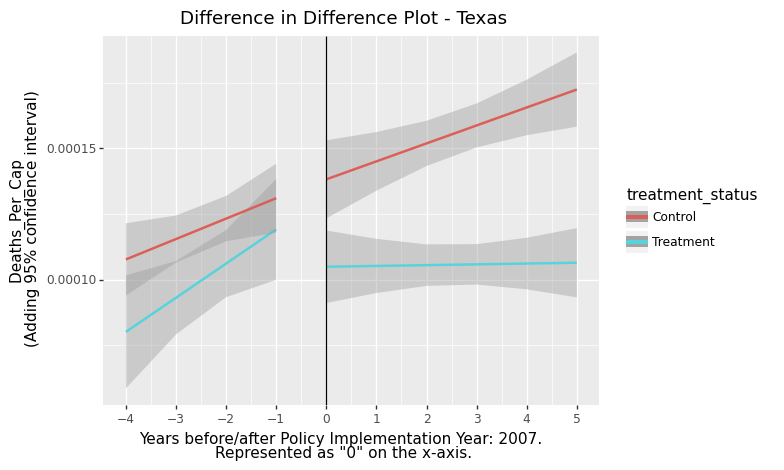

<ggplot: (8763931918014)>


In [133]:
df_treatment_TX = mor_pop[mor_pop['State_Abrv'] == 'TX'].copy()
df_control_TX = mor_pop[(mor_pop['State_Abrv'] == 'AZ') | (mor_pop['State_Abrv'] == 'CA') | (mor_pop['State_Abrv'] == 'OK')].copy()
policy_implementation_year_TX = 2007

df_treatment_TX = df_treatment_TX[(df_treatment_TX['YEAR'] >= 2003) & (df_treatment_TX['YEAR'] <= 2012)]
df_control_TX = df_control_TX[(df_control_TX['YEAR'] >= 2003) & (df_control_TX['YEAR'] <= 2012)]

plot = diff_in_diff_plot(df_treatment_TX, df_control_TX, policy_implementation_year_TX, 'Deaths_Per_Cap')
    
print(plot)

### Washington

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


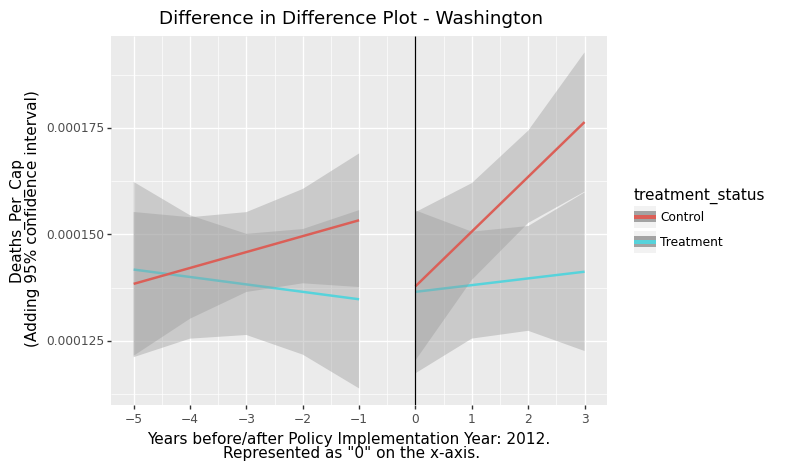

<ggplot: (8763928425036)>


In [134]:
df_treatment_WA = mor_pop[mor_pop['State_Abrv'] == 'WA'].copy()
df_control_WA = mor_pop[(mor_pop['State_Abrv'] == 'UT') | (mor_pop['State_Abrv'] == 'CO') | (mor_pop['State_Abrv'] == 'NC')].copy()
policy_implementation_year_WA = 2012

df_treatment_WA = df_treatment_WA[(df_treatment_WA['YEAR'] >= 2007) & (df_treatment_WA['YEAR'] <= 2015)]
df_control_WA = df_control_WA[(df_control_WA['YEAR'] >= 2007) & (df_control_WA['YEAR'] <= 2015)]

plot = diff_in_diff_plot(df_treatment_WA, df_control_WA, policy_implementation_year_WA, 'Deaths_Per_Cap')
print(plot)

### Florida

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


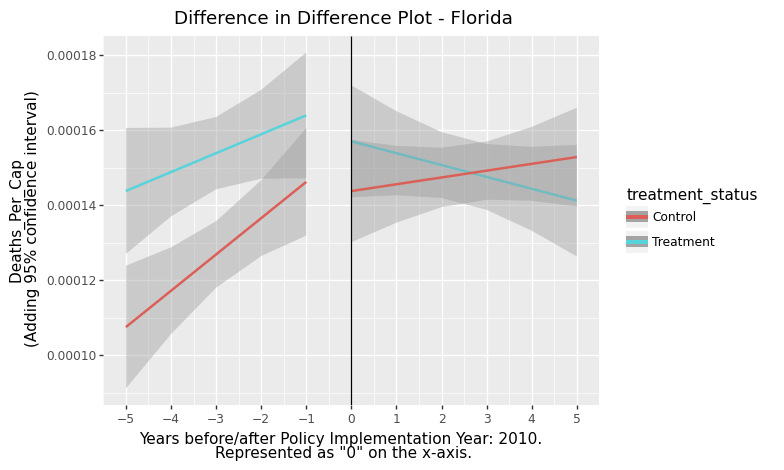

<ggplot: (8763931609245)>


In [135]:
df_treatment_FL = mor_pop[mor_pop['State_Abrv'] == 'FL'].copy()
df_control_FL = mor_pop[(mor_pop['State_Abrv'] == 'AL') | (mor_pop['State_Abrv'] == 'SC') | (mor_pop['State_Abrv'] == 'GA')].copy()
policy_implementation_year_FL = 2010

df_treatment_FL = df_treatment_FL[(df_treatment_FL['YEAR'] >= 2005) & (df_treatment_FL['YEAR'] <= 2015)]
df_control_FL = df_control_FL[(df_control_FL['YEAR'] >= 2005) & (df_control_FL['YEAR'] <= 2015)]

plot = diff_in_diff_plot(df_treatment_FL, df_control_FL, policy_implementation_year_FL, 'Deaths_Per_Cap')
print(plot)

### Pre-Post Plots

### Texas

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


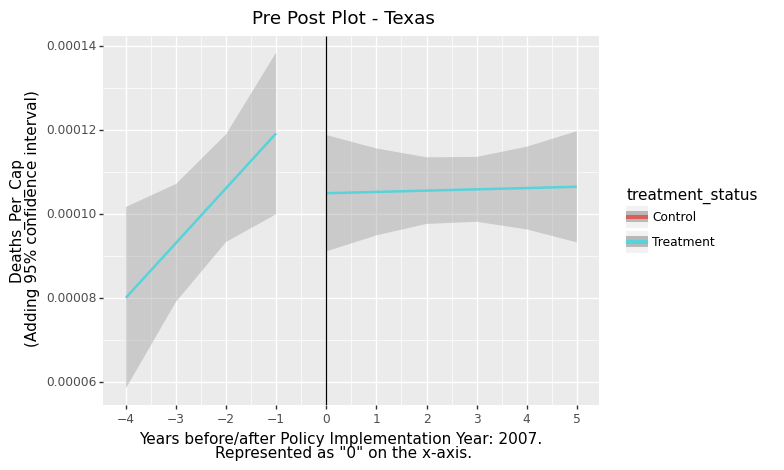

<ggplot: (8763928774003)>


In [136]:
plot = pre_post_plot(df_treatment_TX, policy_implementation_year_TX, 'Deaths_Per_Cap')
print(plot)

### Washington

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


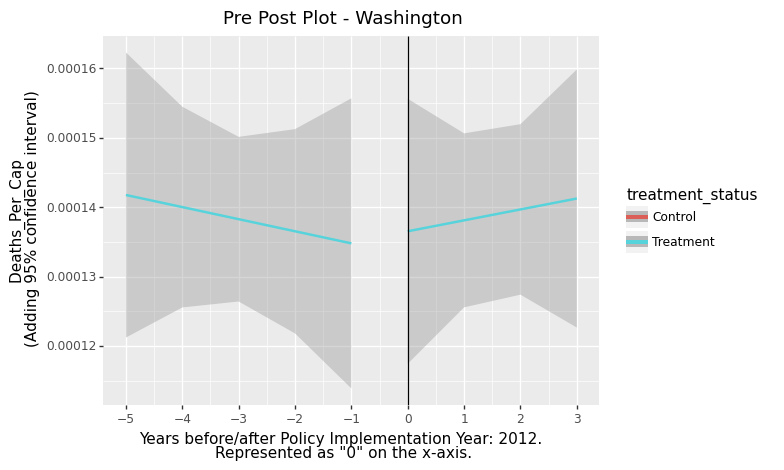

<ggplot: (8763931917894)>


In [137]:
plot = pre_post_plot(df_treatment_WA, policy_implementation_year_WA, 'Deaths_Per_Cap')
print(plot)

### Florida

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


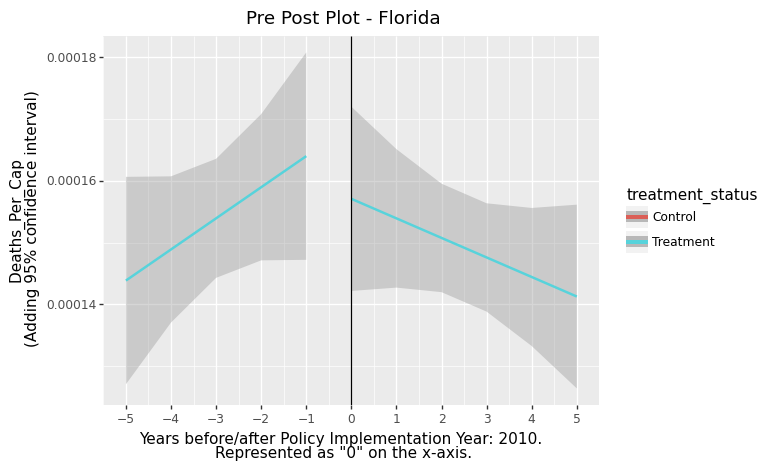

<ggplot: (8763928609762)>


In [138]:
plot = pre_post_plot(df_treatment_FL, policy_implementation_year_FL, 'Deaths_Per_Cap')
print(plot)

# Opioid Shipment Analysis

### Diff in Diff Plots

### Florida

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


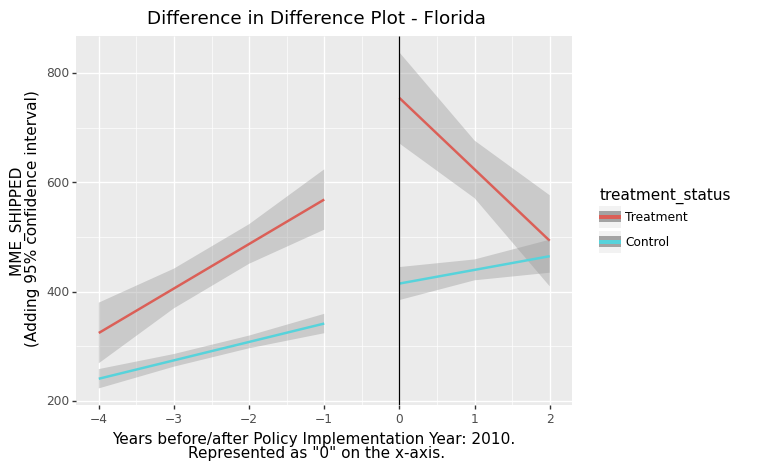

<ggplot: (8763932330153)>


In [139]:
df_treatment_op_pop_FL = op_pop[op_pop['State_Abrv'] == 'FL'].copy()
df_control_op_pop_FL = op_pop[(op_pop['State_Abrv'] == 'AL') | (op_pop['State_Abrv'] == 'SC') | (op_pop['State_Abrv'] == 'GA')].copy()
policy_implementation_year_FL = 2010

plot = diff_in_diff_plot(df_treatment_op_pop_FL, df_control_op_pop_FL, policy_implementation_year_FL, 'MME_SHIPPED')
print(plot)

### Texas

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


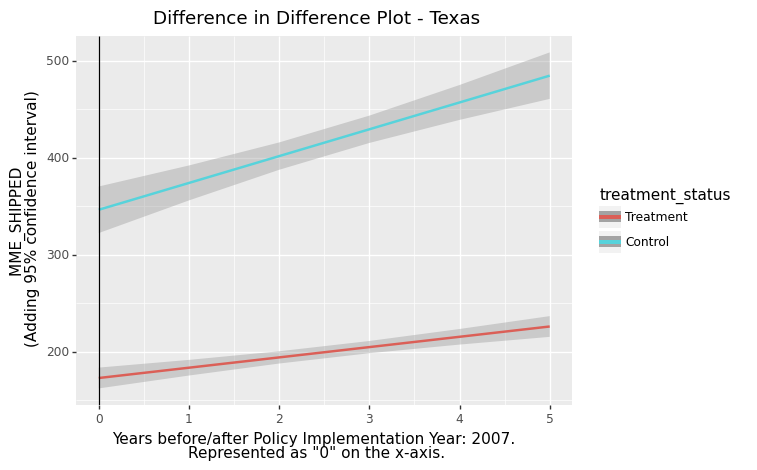

<ggplot: (8763931731438)>


In [140]:
df_treatment_op_pop_TX = op_pop[op_pop['State_Abrv'] == 'TX'].copy()
df_control_op_pop_TX = op_pop[(op_pop['State_Abrv'] == 'CA') | (op_pop['State_Abrv'] == 'AZ') | (op_pop['State_Abrv'] == 'OK')].copy()
policy_implementation_year_TX = 2007

plot = diff_in_diff_plot(df_treatment_op_pop_TX, df_control_op_pop_TX, policy_implementation_year_TX, 'MME_SHIPPED')
print(plot)

### Washington

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


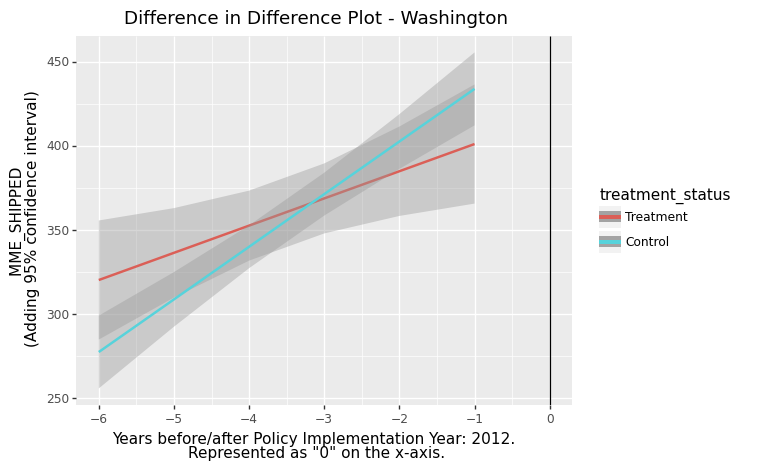

<ggplot: (8763928026564)>


In [141]:
df_treatment_op_pop_WA = op_pop[op_pop['State_Abrv'] == 'WA'].copy()
df_control_op_pop_WA = op_pop[(op_pop['State_Abrv'] == 'CO') | (op_pop['State_Abrv'] == 'UT') | (op_pop['State_Abrv'] == 'NC')].copy()
policy_implementation_year_WA = 2012

plot = diff_in_diff_plot(df_treatment_op_pop_WA, df_control_op_pop_WA, policy_implementation_year_WA, 'MME_SHIPPED')
print(plot)

#### Pre-Post Plots

### Florida

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


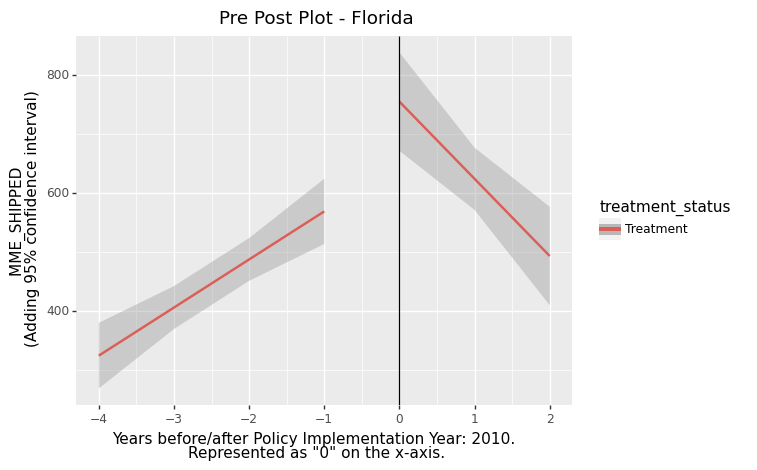

<ggplot: (8763929598202)>


In [142]:
plot = pre_post_plot(df_treatment_op_pop_FL, policy_implementation_year_FL, 'MME_SHIPPED')
print(plot)

### Texas

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


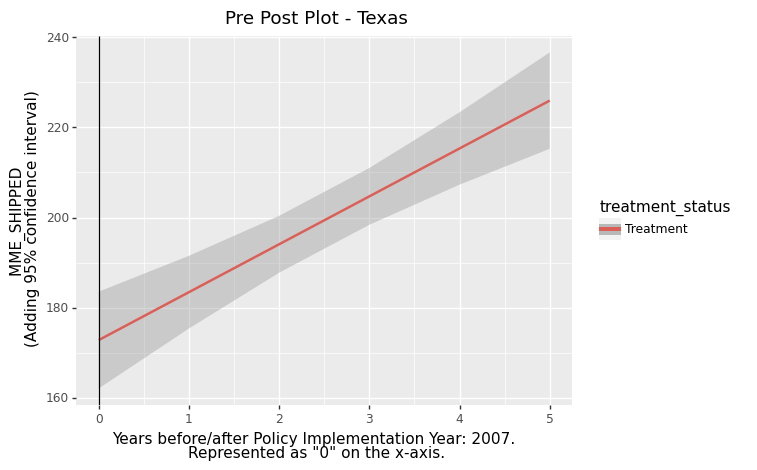

<ggplot: (8763932465264)>


In [143]:
plot = pre_post_plot(df_treatment_op_pop_TX, policy_implementation_year_TX, 'MME_SHIPPED')
print(plot)

### Washington

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


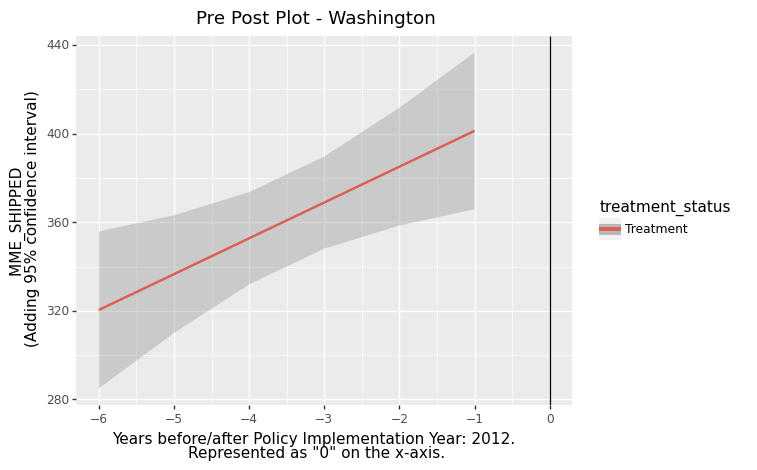

<ggplot: (8763932619015)>


In [144]:
plot = pre_post_plot(df_treatment_op_pop_WA, policy_implementation_year_WA, 'MME_SHIPPED')
print(plot)

## EDA

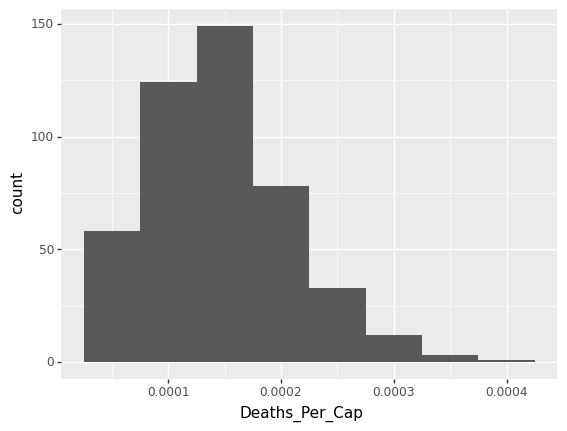

<ggplot: (8763932445097)>

In [145]:
(ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'FL')], 
        aes('Deaths_Per_Cap')) + 
  geom_histogram(binwidth=0.00005)
)

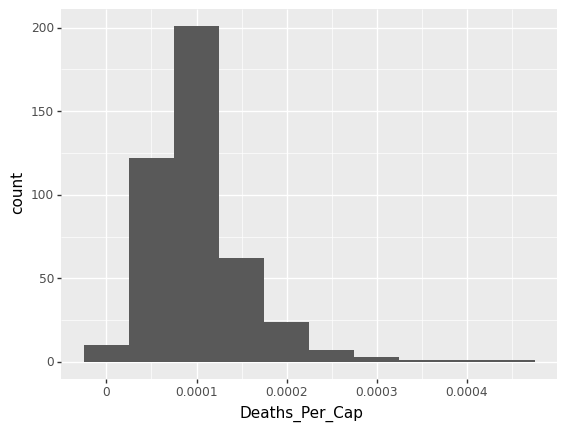

<ggplot: (8763932333195)>

In [146]:
(ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'TX')], 
        aes('Deaths_Per_Cap')) + 
  geom_histogram(binwidth=0.00005)
)

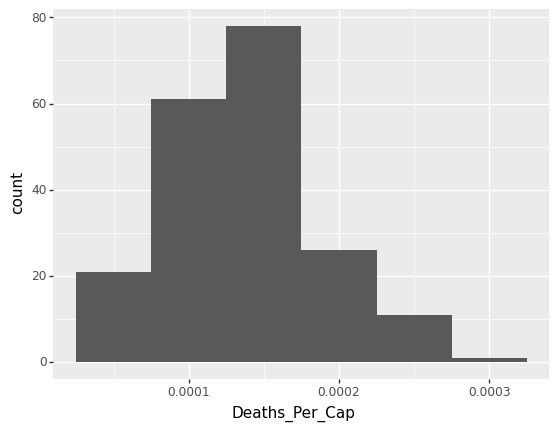

<ggplot: (8763931620596)>

In [147]:
(ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'WA')], 
        aes('Deaths_Per_Cap')) + 
  geom_histogram(binwidth=0.00005)
)

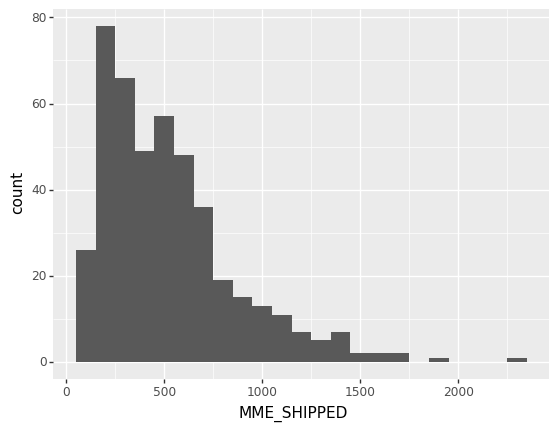

<ggplot: (8763931720427)>

In [148]:
(ggplot(op_pop[(op_pop['treatment_status'] == 'Treatment') & (op_pop['State_Abrv'] == 'FL')], 
        aes('MME_SHIPPED')) + 
  geom_histogram(binwidth = 100)
)

#### 2nd EDA

In [149]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,_merge_old,COUNTY_Abrv,mortality_rate_state_avg,_merge,Deaths_Per_Cap,treatment_status
0,2003,Alabama,NaN,ALABAMA,10.0,4503491,left_only,,0.000012,both,0.000002,Control
1,2003,Alabama,NaN,AUTAUGA COUNTY,1.0,46800,left_only,AUTAUGA,0.000012,both,0.000021,Control
2,2003,Alabama,AL,BALDWIN COUNTY,10.0,151509,both,BALDWIN,0.000012,both,0.000066,Control
3,2003,Alabama,NaN,BARBOUR COUNTY,0.0,28594,left_only,BARBOUR,0.000012,both,0.000000,Control
4,2003,Alabama,NaN,BIBB COUNTY,0.0,21399,left_only,BIBB,0.000012,both,0.000000,Control


/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


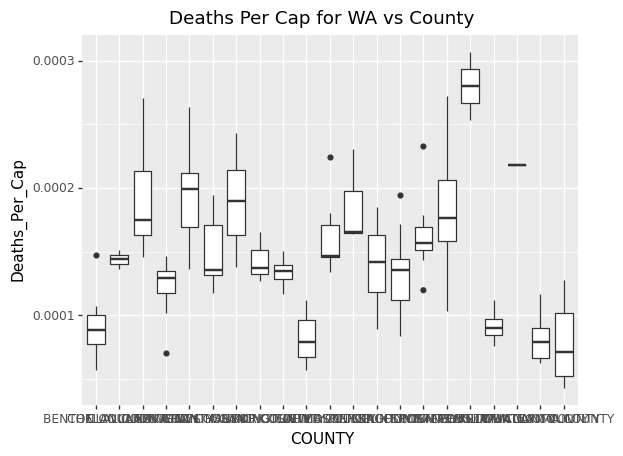

<ggplot: (8763928363801)>

In [150]:
(
ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'WA')],
       aes(x='COUNTY', y='Deaths_Per_Cap')) +
geom_boxplot() +
labs(title="Deaths Per Cap for WA vs County")
)

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


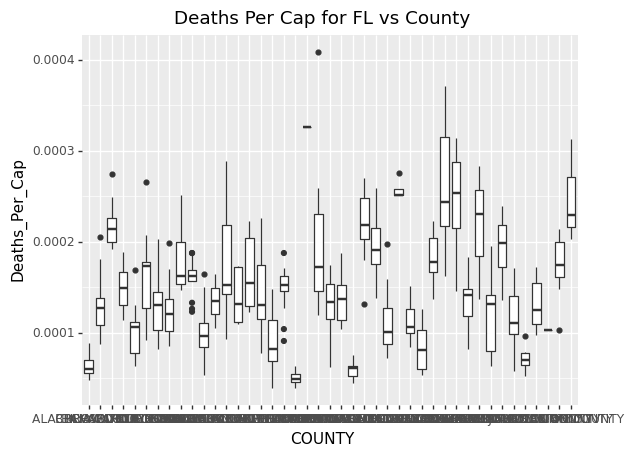

<ggplot: (8763929303914)>

In [151]:
(
ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'FL')],
       aes(x='COUNTY', y='Deaths_Per_Cap')) +
geom_boxplot() +
labs(title="Deaths Per Cap for FL vs County")
)

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


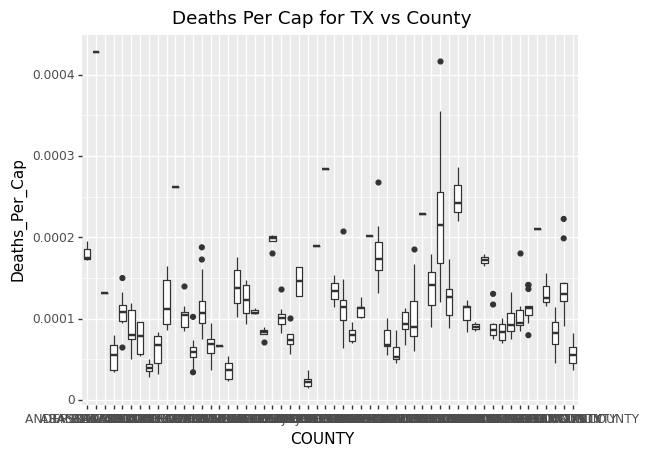

<ggplot: (8763931746949)>

In [152]:
(
ggplot(mor_pop[(mor_pop['treatment_status'] == 'Treatment') & (mor_pop['State_Abrv'] == 'TX')],
       aes(x='COUNTY', y='Deaths_Per_Cap')) +
geom_boxplot() +
labs(title="Deaths Per Cap for TX vs County")
)